In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/Stopień_2/Semestr_2/DNN

In [2]:
# !pip install wfdb --quiet
# !pip install wfdb PyWavelets --quiet

In [68]:
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import wfdb.processing
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tqdm.notebook import tqdm

In [69]:
SEGMENT_LENGTH = 1024 * 8

BATCH_SIZE = 20
BATCHES_PER_EPOCH = 500
LR = 0.00001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TR_DL_PARAMS = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 2,
                'pin_memory': True,
                'persistent_workers': True,
                "prefetch_factor": 2}

In [70]:
class ECGDataset(Dataset):
    def __init__(self, X_path, Y_path, shape):
        self.shape_Normal = tuple(int(i) for i in shape[3:])
        self.shape_Afib = tuple(int(i) for i in shape[:3])
        
        self.X_Normal = torch.from_numpy(np.memmap(X_path + '_Normal.dat', dtype=np.float32, mode='r', shape=self.shape_Normal)).contiguous()
        self.Y_Normal = torch.from_numpy(np.memmap(Y_path + '_Normal.dat', dtype=np.float32, mode='r', shape=self.shape_Normal)).contiguous()
        self.X_Afib = torch.from_numpy(np.memmap(X_path + '_Afib.dat', dtype=np.float32, mode='r', shape=self.shape_Afib)).contiguous()
        self.Y_Afib = torch.from_numpy(np.memmap(Y_path + '_Afib.dat', dtype=np.float32, mode='r', shape=self.shape_Afib)).contiguous()

        self.afib = True
    def __len__(self):
        return max(self.Y_Normal.shape[0], self.Y_Afib.shape[0])
    def __getitem__(self, idx):
      if self.afib:
        X = self.X_Afib[idx % self.X_Afib.shape[0], :, :]
        Y = self.Y_Afib[idx % self.Y_Afib.shape[0],  :, :]
      else:
        X = self.X_Normal[idx % self.X_Normal.shape[0], :, :]
        Y = self.Y_Normal[idx % self.Y_Normal.shape[0],  :, :]
      self.afib = not(self.afib)
      return X, Y

In [71]:
import json
def create_data_loader(db_names, params):
  with open('Dataset2/metadata/metadata.json', 'r') as file:
    md = json.load(file)
  print(md)
  X_paths = [f'Dataset/{db_name}_signals' for db_name in db_names]
  Y_paths = [f'Dataset/{db_name}_labels' for db_name in db_names]
  shapes = [md[db_name]["shape"] for db_name in db_names]
  dataset = ConcatDataset([ECGDataset(xp, yp, shape) for xp, yp, shape in zip(X_paths, Y_paths, shapes)])
  tr_loader = DataLoader(dataset, **params)
  return tr_loader, dataset

In [72]:
train_loader_af_mb, ds_af_mb = create_data_loader(('MIT_BIH0', 'AF_long0', 'AF_long1', 'AF_long2', 'AF_long3', 'jap0', 'jap1', 'jap2', 'jap3', 'jap4', 'jap5'), params=TR_DL_PARAMS)

{'MIT_BIH0': {'shape': [34370, 1, 2048, 52628, 1, 2048]}, 'jap0': {'shape': [30160, 1, 2048, 140622, 1, 2048]}, 'jap1': {'shape': [29682, 1, 2048, 142964, 1, 2048]}, 'jap2': {'shape': [24238, 1, 2048, 141450, 1, 2048]}, 'jap3': {'shape': [46634, 1, 2048, 125816, 1, 2048]}, 'jap4': {'shape': [34258, 1, 2048, 138612, 1, 2048]}, 'jap5': {'shape': [23088, 1, 2048, 149748, 1, 2048]}, 'AF_long0': {'shape': [49580, 1, 2048, 96098, 1, 2048]}, 'AF_long1': {'shape': [49796, 1, 2048, 98156, 1, 2048]}, 'AF_long2': {'shape': [47846, 1, 2048, 90890, 1, 2048]}, 'AF_long3': {'shape': [25482, 1, 2048, 108316, 1, 2048]}, 'AF_long4': {'shape': [22194, 1, 2048, 112110, 1, 2048]}, 'AF_long5': {'shape': [53582, 1, 2048, 85466, 1, 2048]}}


In [73]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y

class UNet1D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=64):
        super(UNet1D, self).__init__()
        features = init_features

        # Encoder
        self.encoder1 = UNet1D._block(in_channels, features, name="enc1")
        self.down1 = nn.Conv1d(features, features, kernel_size=3, stride=2, padding=1)

        self.encoder2 = UNet1D._block(features, features * 2, name="enc2")
        self.down2 = nn.Conv1d(features * 2, features * 2, kernel_size=3, stride=2, padding=1)

        self.encoder3 = UNet1D._block(features * 2, features * 4, name="enc3")
        self.down3 = nn.Conv1d(features * 4, features * 4, kernel_size=3, stride=2, padding=1)

        self.encoder4 = UNet1D._block(features * 4, features * 8, name="enc4")
        self.down4 = nn.Conv1d(features * 8, features * 8, kernel_size=3, stride=2, padding=1)

        # Bottleneck
        self.bottleneck = UNet1D._block(features * 8, features * 16, name="bottleneck")

        # Decoder
        self.upconv4 = nn.ConvTranspose1d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet1D._block(features * 16, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose1d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet1D._block(features * 8, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose1d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet1D._block(features * 4, features * 2, name="dec2")

        self.upconv1 = nn.ConvTranspose1d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet1D._block(features * 2, features, name="dec1")

        # Output layer
        self.conv = nn.Conv1d(features, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.down1(enc1))
        enc3 = self.encoder3(self.down2(enc2))
        enc4 = self.encoder4(self.down3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.down4(enc4))

        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Output layer
        output = self.conv(dec1)
        return output

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv1d(in_channels, features, kernel_size=3, padding=1),
            nn.BatchNorm1d(features),  # Batch Normalization
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),  # Dropout with 30% probability
            nn.Conv1d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm1d(features),  # Batch Normalization
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.3),  # Dropout with 30% probability
            SEBlock(features)  # Attention Mechanism
        )

In [74]:
class CombinedBCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.4, dice_weight=0.6):
        super(CombinedBCEDiceLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        smooth = 1e-5  # To avoid division by zero
        outputs_flat = outputs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (outputs_flat * targets_flat).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (outputs_flat.sum() + targets_flat.sum() + smooth)
        return (self.bce_weight * bce_loss) + (self.dice_weight * dice_loss)


In [76]:
model = UNet1D(in_channels=1, out_channels=1).to(DEVICE)
# criterion = nn.BCEWithLogitsLoss()
criterion = CombinedBCEDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

/tmp/ipykernel_13768/321186321.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/novuum_@FIN2_30.pt', map_location=DEVICE))


<All keys matched successfully>

In [77]:
import torchaudio
import random

def resample_batch(x, y):
  random_fs = random.randint(96, 160)
  R = torchaudio.transforms.Resample(128, random_fs)
  x = torch.clip(R(x), min=0, max=1)
  y = R(y) >= 0.5
  divisable_len = x.shape[2] - x.shape[2] % 16
  x = x[:, :, :divisable_len]
  y = y[:, :, :divisable_len]
  return x, y

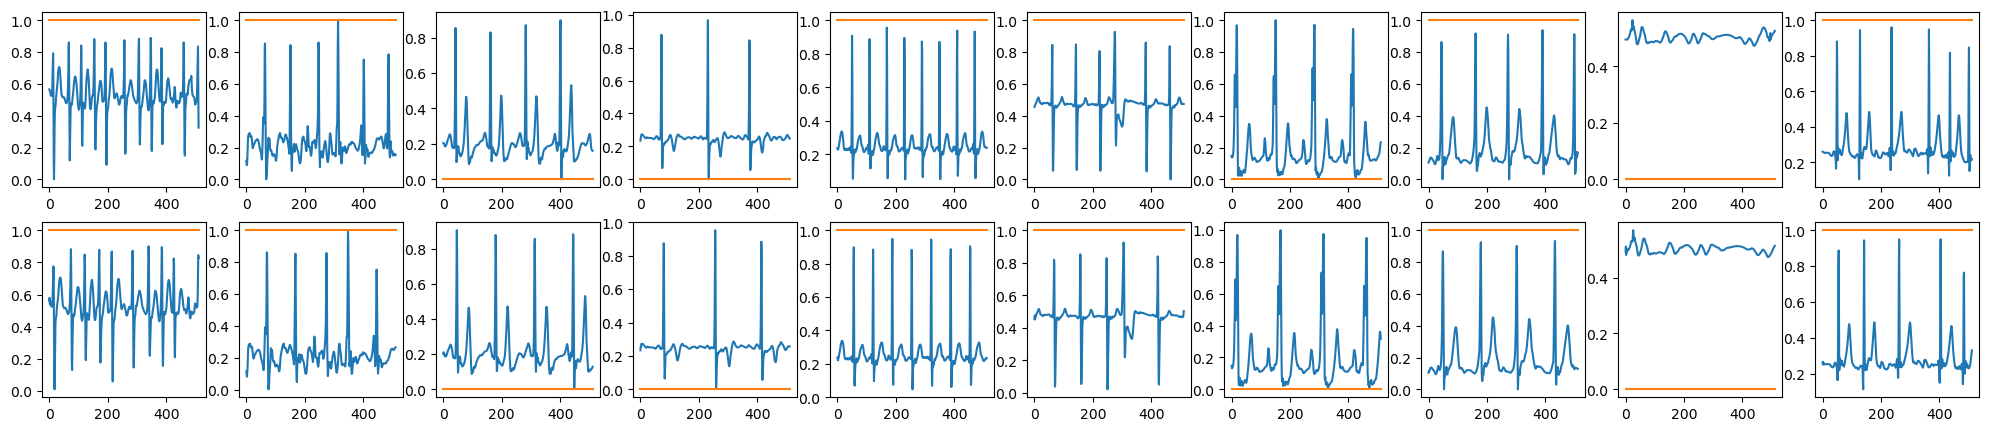

In [78]:
# Test dataloadea
x, y = next(iter(train_loader_af_mb))
fig, ax = plt.subplots(2, 10, figsize=(25, 5))

for j in range(10):
  ax[0, j].plot(x.cpu()[j, 0, :512])
  ax[0, j].plot(y.cpu()[j, 0, :512])

a, b = resample_batch(x, y)

for j in range(10):
  ax[1, j].plot(a.cpu()[j, 0, :512])
  ax[1, j].plot(b.cpu()[j, 0, :512])
plt.show()


In [79]:
def create_ann_mask(ann, signal_len):
    label = np.zeros((signal_len,1), dtype=bool)
    aux_notes = ann.aux_note
    samples = np.append(ann.sample, signal_len)
    aux_notes.append('END')
    start = 0
    is_afib = False
    for i, note in enumerate(aux_notes):
        if note == '(AFIB':
            is_afib = True
            start = samples[i]
        elif note != '' and is_afib:
            end = samples[i]
            label[start:end] = True
            is_afib = False
    return label

In [80]:
from abc import ABC

class ISignalReader(ABC):
    def __init__(self, path):
        self.sig, self.fields = wfdb.rdsamp(path)
    def read_signal(self) -> np.ndarray:
        return self.sig
    def read_fs(self) -> float:
        return self.fields['fs']
    def get_code(self) -> str:
        return 'aaa'


In [81]:
class RecordEvaluator:
    def __init__(self, dest_dir, model_path="model.pt"):
        self._dest_dir = dest_dir
        self.target_fs = 128
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = UNet1D(in_channels=1, out_channels=1).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.segment_length = 1024 * 2
        self.stride = 512
        self.model.eval()

    def denoise_ecg(self, signal, wavelet="db4", level=4, thresholding="soft"):
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(len(signal)))
        for i in range(1, len(coeffs)):
            coeffs[i] = pywt.threshold(coeffs[i], threshold, mode=thresholding)
        denoised_signal = pywt.waverec(coeffs, wavelet)
        return denoised_signal

    def evaluate(self, signal_reader: ISignalReader):
        sig = signal_reader.read_signal()
        fs = signal_reader.read_fs()
        sig, _ = wfdb.processing.resample_sig(sig[:, 0], fs, self.target_fs)
        sig = self.denoise_ecg(sig)
        sig = wfdb.processing.normalize_bound(sig)
        sig = torch.from_numpy(sig).unsqueeze(0).unsqueeze(0).float().to(self.device)

        out = torch.zeros(size=(sig.size()[2],), dtype=torch.float32).to(self.device)
        count = torch.zeros(size=(sig.size()[2],), dtype=torch.float32).to(self.device)

        with torch.no_grad():
            for i in range(0, sig.size()[2] - self.segment_length + 1, self.stride):
                fragment = sig[:, :, i : i + self.segment_length]
                out[i : i + self.segment_length] += torch.sigmoid(self.model(fragment)).squeeze() >= 0.5
                count[i : i + self.segment_length] += 1
        out = out / count
        out = out.cpu().numpy()
        result = wfdb.processing.resample_sig(out, self.target_fs, fs)[0]
        result = result >= 0.5

        code = signal_reader.get_code()
        np.save(os.path.join(self._dest_dir, f"{code}"), result)
        return result

In [82]:
def ewaluacja(model_path):
  a_total, p_total, r_total, f_total = 0, 0, 0, 0
  record_evaluator = RecordEvaluator('aaa', model_path)
  eval_records = np.loadtxt("Dataset2/metadata/validation_records.txt", dtype=str)
  info = f'-----------------------------\nEvaluating: {model_path}'
  with tqdm(total=len(eval_records), desc="Validation : ") as pbar:
    with open('logs/log.txt', 'a') as file:
      file.write(info + '\n')
    for record in eval_records:
      out = record_evaluator.evaluate(signal_reader=ISignalReader(record))
      ann_raw = wfdb.rdann(record, extension='atr')
      ann = create_ann_mask(ann_raw, len(out))
      acc = accuracy_score(out, ann)
      p, r, f, s = precision_recall_fscore_support(ann, out, average='binary')
      metrics = f'record name : {record}, accuracy : {acc}, precision : {p}, recall : {r}, f-score : {f}, support : {s}'
      with open('logs/log.txt', 'a') as file:
        file.write(metrics + '\n')
      print(metrics)
      a_total += acc
      p_total += p
      r_total += r
      f_total += f
      pbar.update(1)
  a_total = a_total / len(eval_records)
  p_total = p_total / len(eval_records)
  r_total = r_total / len(eval_records)
  f_total = f_total / len(eval_records)
  total_metrics = f'average accuracy : {a_total}, average precision : {p_total}, average recall : {r_total}, average f-score : {f_total}'
  with open('logs/log.txt', 'a') as file:
    file.write(total_metrics + '\n')
  return a_total, p_total, r_total,f_total


In [83]:
def model_train(num_epochs, train_loader, model_name):
    validation_metrics = []
    accuracies = []
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        with tqdm(total=BATCHES_PER_EPOCH, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as pbar:
            for i, (signals, labels) in enumerate(train_loader):
                if i >= BATCHES_PER_EPOCH:
                    break
                signals, labels = resample_batch(signals, labels)
                signals = signals.to(DEVICE, non_blocking=True)
                labels = labels.to(DEVICE, non_blocking=True).float()
                outputs = model(signals)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                
                total += labels.numel()
                correct += (labels == (torch.sigmoid(outputs) > 0.5)).sum().item()
                running_loss += loss.item()

                pbar.update(1)

        accuracy = correct / total
        accuracies.append(accuracy)
        avg_loss = running_loss / BATCHES_PER_EPOCH
        losses.append(avg_loss)
        torch.save(model.state_dict(), f'models/{model_name}_{epoch}.pt')
        if epoch % 80 == 0 and epoch != 0:
          m = ewaluacja(f'models/{model_name}_{epoch}.pt')
          validation_metrics.append(m)
          torch.cuda.empty_cache()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        with open("logs/log_train.txt", 'a') as file:
            file.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}\n")
        gc.collect()

    return np.array(validation_metrics).T, np.array(accuracies), np.array(losses)

In [ ]:
NUM_EPOCHS = 1000
val_m, train_a, train_l = model_train(num_epochs=NUM_EPOCHS, train_loader=train_loader_af_mb, model_name='fina')

Epoch 1/1000:   0%|          | 0/500 [00:00<?, ?it/s]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

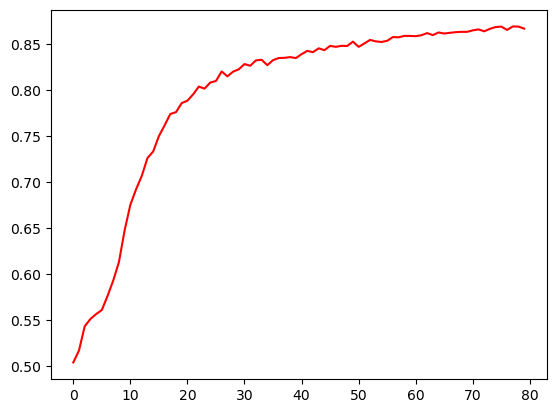

In [72]:
plt.figure()
plt.plot(np.arange(NUM_EPOCHS), train_a, color='r')
for i in range(4):
  plt.plot(np.arange(NUM_EPOCHS), val_m[i, :])
plt.show()